# COGS 108 - EDA Checkpoint

# Names

- Victoria Thai
- Hannah Yick
- Jane Dinh
- Natasha Supangkat
- Gabriel Ramiro

<a id='research_question'></a>
# Research Question

What trends can be found between a county’s designation of a superfund site and its socioeconomic/demographic trends? Does the demographic makeup of a county influence the amount of time between Superfund designation and the completion of the remediation process?

# Setup

In [1]:
#Imports 
import pandas as pd
import numpy as np

#Graphing
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

#Statistics
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

#Webscraping
import requests 
import bs4
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

# Read in the data and store it within a data frame
#npl_df = npl_df = pd.read_csv('https://raw.githubusercontent.com/COGS108/group011_sp21/main/All%20current%20Final%20NPL%20Sites%20(FOIA%204).csv?token=AI2VKGQIIMQPBWGAZGPKD5DASR4CO') 
gdrive_npl_id = '1oDIJ_v9s5i5THULln_C-N4o3Aiz0e7mu'
npl_df = pd.read_csv(f'https://docs.google.com/uc?id={gdrive_npl_id}&export=download', encoding='ISO-8859-1')
gdrive_acs_id = '1kNWY1Kc4RhQ9ttK7dTYtj0fhHE3BXOGh'
acs_df = pd.read_csv(f'https://docs.google.com/uc?id={gdrive_acs_id}&export=download', encoding='ISO-8859-1')

pd.options.display.max_rows = 5
pd.options.display.max_columns = 8

# Data Cleaning

Data cleaning from Checkpoint 1.

In [2]:
npl_df = npl_df.drop(["Region", "Site ID", "EPA ID", "Address", "Zip", "FF Ind", "Latitude", "Longitude"], axis=1)

In [3]:
acs_df = acs_df.drop([0], axis=0)
acs_df.reset_index(drop=True, inplace=True)

acs_df.dropna(axis = 0, how = 'all', inplace = True)
acs_df.dropna(axis = 1, how = 'all', inplace = True)

acs_df.drop(labels=['FIPS', 'Geographic Identifier', 'Summary Level', 'Geographic Component', 
                    'File identification', 'Logical Record Number', 'State (FIPS Code)', 
                    'County of current residence', 'Total Population.1', 'Population Density (Per Sq. Mile)', 
                    'Area (Land)', 'Total Population:', 'Total Population: White Alone', 
                    'Total Population: Black or African American Alone', 
                    'Total Population: American Indian and Alaska Native Alone', 'Total Population: Asian Alone', 
                    'Total Population: Native Hawaiian and Other Pacific Islander Alone', 
                    'Total Population: Some Other Race Alone', 'Total Population: Two or More Races'], axis=1, inplace = True)
acs_df.drop(index=acs_df[acs_df['State Postal Abbreviation'] == 'pr'].index, inplace=True)
acs_df.drop(list(acs_df.filter(regex = 'At or Above Poverty Level')), axis = 1, inplace = True)

acs_df = acs_df.iloc[:, np.r_[0:11, 12:23, 34, 37, 40, 43, 46, 49, 52, 55, 58, 61, 64, 67]]

We'll need to adjust our dataset now that we have a better understanding of our data and how we want to work with it. Here, we'll work towards merging our two datasets by county. Let's start by standardizing the county variable of both datasets with a format of 'COUNTY, PC' where PC is the postal code (i.e. CA for California). This will handle instances where there are counties of the same name in different states.

First, let's take a look at our NPL dataset.

In [4]:
npl_df.sample(n=10)

,State,Site Name,City,County,NPL Status Date
302,PR,DORADO GROUND WATER CONTAMINATION,DORADO,DORADO,9/9/2016
1090,NE,SHERWOOD MEDICAL CO.,NORFOLK,MADISON,10/14/1992
...,...,...,...,...,...
957,OK,HENRYETTA IRON AND METAL,HENRYETTA,OKMULGEE,9/3/2020
1060,MO,RIVERFRONT,NEW HAVEN,FRANKLIN,12/1/2000


Let's examine the dataset and check for missingness.

In [5]:
npl_df.isna().sum().sum()

20

In [6]:
npl_df.isna().any()

State              False
Site Name          False
City               False
County              True
NPL Status Date    False
dtype: bool

From this, we can see that all the missing data is in the County variable.

In [7]:
#subset to just rows with missing data
npl_df[npl_df.isnull().any(axis=1)]

,State,Site Name,City,County,NPL Status Date
266,NY,NEWTOWN CREEK,"BROOKLYN, QUEENS",NaN,9/29/2010
303,PR,FIBERS PUBLIC SUPPLY WELLS,JOBOS,NaN,9/21/1984
...,...,...,...,...,...
1263,ID,EASTERN MICHAUD FLATS CONTAMINATION,POCATELLO,NaN,8/30/1990
1264,ID,IDAHO NATIONAL ENGINEERING LABORATORY (USDOE),IDAHO FALLS,NaN,11/21/1989


We can see from the subset of missing data that these NPL sites are in valid cities in the United States, so there's no reason to drop them; however, they do not have data for the county. We will have to manually input these county values so that we can merge successfully before we go any further.

In [8]:
# manually input county names here
npl_df['County'][266] = 'KINGS-QUEENS'
npl_df['County'][303] = 'GUYAMA'
npl_df['County'][306] = 'UTUADO'
npl_df['County'][311] = 'TOA BAJA'
npl_df['County'][314] = 'VEGA ALTA'
npl_df['County'][495] = 'MORGAN-MADISON-LIMESTONE'
npl_df['County'][644] = 'AIKEN-ALLENDALE-BARNWELL'
npl_df['County'][661] = 'ANDERSON'
npl_df['County'][853] = 'HAMILTON'
npl_df['County'][881] = 'GREENE '
npl_df['County'][1127] = 'BUTTE-SILVER BOW'
npl_df['County'][1129] = 'MEADE'
npl_df['County'][1134] = 'DAVIS'
npl_df['County'][1256] = 'ALEUTIANS WEST CENSUS AREA'
npl_df['County'][1258] = 'ANCHORAGE'
npl_df['County'][1259] = 'ANCHORAGE'
npl_df['County'][1260] = 'FAIRBANKS NORTH STAR'
npl_df['County'][1261] = 'PRINCE OF WALES-HYDER CENSUS AREA'
npl_df['County'][1263] = 'BANNOCK'
npl_df['County'][1264] = 'BUTTE'

In [9]:
# clarify that all missing data has been addressed
npl_df.isna().sum().sum()

0

Now that all the county information is included, we'll convert the column names into lowercase, and continue this use of lowercase column names as we progress with both datasets as a standardization measure.

In [10]:
npl_df.columns = ['state', 'site name', 'city', 'county', 'npl status date']
npl_df.head()

,state,site name,city,county,npl status date
0,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,BARKHAMSTED,LITCHFIELD,10/4/1989
1,CT,BEACON HEIGHTS LANDFILL,BEACON FALLS,NEW HAVEN,9/8/1983
2,CT,DURHAM MEADOWS,DURHAM,MIDDLESEX,10/4/1989
3,CT,GALLUP'S QUARRY,PLAINFIELD,WINDHAM,10/4/1989
4,CT,KELLOGG-DEERING WELL FIELD,NORWALK,FAIRFIELD,9/21/1984


Next we'll get our county variable information into the correct format by concatenating the state postal code.

In [11]:
npl_df['county'] = npl_df['county'].map(str) + ', ' + npl_df['state'].map(str)
npl_df.head()

,state,site name,city,county,npl status date
0,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,BARKHAMSTED,"LITCHFIELD, CT",10/4/1989
1,CT,BEACON HEIGHTS LANDFILL,BEACON FALLS,"NEW HAVEN, CT",9/8/1983
2,CT,DURHAM MEADOWS,DURHAM,"MIDDLESEX, CT",10/4/1989
3,CT,GALLUP'S QUARRY,PLAINFIELD,"WINDHAM, CT",10/4/1989
4,CT,KELLOGG-DEERING WELL FIELD,NORWALK,"FAIRFIELD, CT",9/21/1984


In addition, we added a Duration column that will come into play as we plot our data. The values in this variable are the number of years since NPL status for the site was established (up to 2021).

In [12]:
npl_df['duration'] = npl_df['npl status date'].str[-4:]
npl_df = npl_df.astype({"duration": int})
npl_df['duration'] = 2021 - npl_df['duration']
npl_df

,state,site name,city,county,npl status date,duration
0,CT,BARKHAMSTED-NEW HARTFORD LANDFILL,BARKHAMSTED,"LITCHFIELD, CT",10/4/1989,32
1,CT,BEACON HEIGHTS LANDFILL,BEACON FALLS,"NEW HAVEN, CT",9/8/1983,38
...,...,...,...,...,...,...
1325,WA,"WESTERN PROCESSING CO., INC.",KENT,"KING, WA",9/8/1983,38
1326,WA,WYCKOFF CO./EAGLE HARBOR,BAINBRIDGE ISLAND,"KITSAP, WA",7/22/1987,34


Now we can take a look at our ACS dataset.

In [13]:
acs_df.head()

,Area Name,Qualifying Name,State Postal Abbreviation,Total Population,...,% Some Other Race Alone Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Two or More Races Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level,"% White Alone, Not Hispanic or Latino Population for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level"
0,Autauga County,"Autauga County, Alabama",al,55380,...,26.19,16.97,4.37,11.12
1,Baldwin County,"Baldwin County, Alabama",al,212830,...,26.28,10.79,18.41,8.4
2,Barbour County,"Barbour County, Alabama",al,25361,...,50.34,55.85,61.25,14.71
3,Bibb County,"Bibb County, Alabama",al,22493,...,NaN,0,0,16.34
4,Blount County,"Blount County, Alabama",al,57681,...,2.64,19.1,25.46,12.33


We'll need to standardize the formatting for the column describing the county of each observation to match that of our NPL datset, which is of the format 'COUNTY, PC' with PC being the postal code abbreviation. We can achieve this using the .upper(), .replace(), and .strip() methods.

In [14]:
acs_df.rename({'Area Name': 'county'}, axis=1, inplace=True)
acs_df['State Postal Abbreviation'] = acs_df['State Postal Abbreviation'].str.upper()
acs_df['county'] = acs_df['county'].str.upper()
acs_df['county'] = acs_df['county'].str.replace('COUNTY', '')
acs_df['county'] = acs_df['county'].str.strip()
acs_df['county'] = acs_df['county'].map(str) + ', ' + acs_df['State Postal Abbreviation'].map(str)
acs_df.head()

,county,Qualifying Name,State Postal Abbreviation,Total Population,...,% Some Other Race Alone Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Two or More Races Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level,"% White Alone, Not Hispanic or Latino Population for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level"
0,"AUTAUGA, AL","Autauga County, Alabama",AL,55380,...,26.19,16.97,4.37,11.12
1,"BALDWIN, AL","Baldwin County, Alabama",AL,212830,...,26.28,10.79,18.41,8.4
2,"BARBOUR, AL","Barbour County, Alabama",AL,25361,...,50.34,55.85,61.25,14.71
3,"BIBB, AL","Bibb County, Alabama",AL,22493,...,NaN,0,0,16.34
4,"BLOUNT, AL","Blount County, Alabama",AL,57681,...,2.64,19.1,25.46,12.33


Now that we have a common column, we can merge our datasets. We'll use a left merge with our NPL dataset as our left-dataset, since we only need the demographic data for the county of the NPL sites.

In [15]:
county_df = pd.merge(npl_df, acs_df, on='county', how='left')
county_df = county_df.sort_values(by=['county'])
county_df.sample(n=5)

,state,site name,city,county,...,% Some Other Race Alone Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Two or More Races Population for Whom Poverty Status Is Determined: Income Below Poverty Level,% Hispanic or Latino Population for Whom Poverty Status Is Determined: Income Below Poverty Level,"% White Alone, Not Hispanic or Latino Population for Whom&nbsp; Poverty Status Is Determined: Income Below Poverty Level"
498,FL,AIRCO PLATING CO.,MIAMI,"MIAMI-DADE, FL",...,16.52,14.79,16.84,9.55
800,MI,ROSE TOWNSHIP DUMP,ROSE TOWNSHIP,"OAKLAND, MI",...,18.96,15.36,15.73,6.51
636,SC,LEXINGTON COUNTY LANDFILL AREA,CAYCE,"LEXINGTON, SC",...,35.53,18.97,28.48,9.61
470,VA,"RENTOKIL, INC. (VIRGINIA WOOD PRESERVING DIVIS...",RICHMOND,"HENRICO, VA",...,24.88,12.59,20.1,6.47
743,IN,MIDCO II,GARY,"LAKE, IN",...,22.8,23.56,18.86,8.72


# Data Analysis & Results (EDA)

### Median Household Income

Let's narrow down the scope of our dataset for this portion - we'll create a subset using just the relevant variables, including county, site name, and median household income. We'll also drop any rows in the subset with missing data for median household income, as this is essential to our current exploration.

In [16]:
mhi_df = county_df[['site name', 'county', 'Median Household Income (In 2019 Inflation Adjusted Dollars):']]
mhi_df.rename({'Median Household Income (In 2019 Inflation Adjusted Dollars):': 'median household income'}, axis=1, inplace=True)
mhi_df = mhi_df.dropna(subset=['median household income'])
mhi_df['median household income'] = mhi_df['median household income'].astype(int)
mhi_df

,site name,county,median household income
1094,BRODERICK WOOD PRODUCTS,"ADAMS, CO",71202
1107,ROCKY MOUNTAIN ARSENAL (USARMY),"ADAMS, CO",71202
...,...,...,...
461,LANGLEY AIR FORCE BASE/NASA LANGLEY RESEARCH C...,"YORK, VA",92069
1152,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",45243


Visualizing the distribution of median household income for all of the relevant counties might be difficult - we have thousands of observations. We'll create two more subsets and compare their distributions:
1. 10 counties with the most NPL sites
2. 10 counties with the least NPL sites

We can start by getting a list of counties in order of their frequency in the dataset; we'll use the .value_counts() and .index.tolist() methods.

In [17]:
mhi_df.value_counts(['county'])

county         
SANTA CLARA, CA    21
MONTGOMERY, PA     17
                   ..
HENRY, AL           1
YUMA, AZ            1
Length: 621, dtype: int64

In [18]:
counties = mhi_df['county'].value_counts().index.tolist()

Now let's create the subsets by slicing the list into two lists of 10 counties.

In [19]:
top_10 = counties[0:10]
bottom_10 = counties[506:516]

In [20]:
top_10

['SANTA CLARA, CA',
 'LOS ANGELES, CA',
 'MONTGOMERY, PA',
 'NASSAU, NY',
 'MIDDLESEX, NJ',
 'MIDDLESEX, MA',
 'HARRIS, TX',
 'HILLSBOROUGH, FL',
 'NEW CASTLE, DE',
 'BURLINGTON, NJ']

In [21]:
mhi_top_df = mhi_df[mhi_df['county'].isin(top_10)]
mhi_top_df.head()

,site name,county,median household income
153,LANG PROPERTY,"BURLINGTON, NJ",87416
152,LANDFILL & DEVELOPMENT CO.,"BURLINGTON, NJ",87416
189,ROEBLING STEEL CO.,"BURLINGTON, NJ",87416
149,"KAUFFMAN & MINTEER, INC.","BURLINGTON, NJ",87416
163,MCGUIRE AIR FORCE BASE #1,"BURLINGTON, NJ",87416


In [22]:
bottom_10

['NEW LONDON, CT',
 'ASHLAND, WI',
 'HENRICO, VA',
 'LANE, OR',
 'BERKSHIRE, MA',
 'CLEAR CREEK, CO',
 'PASSAIC, NJ',
 'BUTLER, NE',
 'MONTGOMERY, AL',
 'MADISON, MO']

In [23]:
mhi_bottom_df = mhi_df[mhi_df['county'].isin(bottom_10)]
mhi_bottom_df.head()

,site name,county,median household income
885,ASHLAND/NORTHERN STATES POWER LAKEFRONT,"ASHLAND, WI",42510
36,ROSE DISPOSAL PIT,"BERKSHIRE, MA",59230
1076,BRUNO CO-OP ASSOCIATION/ASSOCIATED PROPERTIES,"BUTLER, NE",58979
1097,"CENTRAL CITY, CLEAR CREEK","CLEAR CREEK, CO",67060
470,"RENTOKIL, INC. (VIRGINIA WOOD PRESERVING DIVIS...","HENRICO, VA",70307


Text(0, 0.5, 'County')

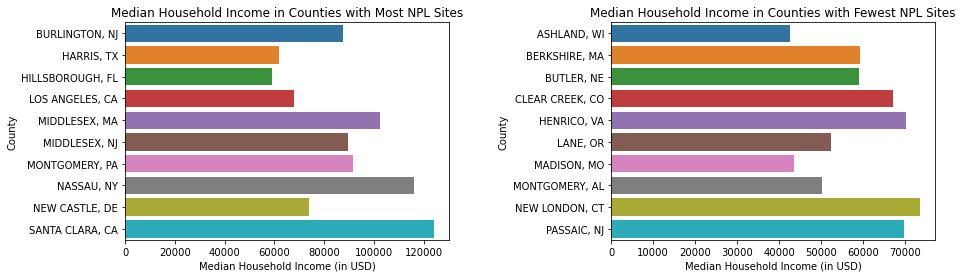

In [24]:
fig, ax =plt.subplots(1,2)
plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=0.5, hspace=None)

ax1 = sns.barplot(x="median household income", y="county", data=mhi_top_df, ax=ax[0])

ax1.set_title('Median Household Income in Counties with Most NPL Sites')
ax1.set_xlabel('Median Household Income (in USD)')
ax1.set_ylabel('County')

ax2 = sns.barplot(x="median household income", y="county", data=mhi_bottom_df, ax=ax[1])

ax2.set_title('Median Household Income in Counties with Fewest NPL Sites')
ax2.set_xlabel('Median Household Income (in USD)')
ax2.set_ylabel('County')

The results are interesting - it seems as if the subset of counties with just 1 NPL site has higher median household income measures than the subset of counties with the most. This is revealing the limitation of the mhi_bottom_df subset in that there are many counties with just 1 NPL site, so the 10 in our sample might not be generalizable to the rest. As we move forward, we have several options: we can randomize the 10 counties in our sample (not just those at the bottom of the list), increase our sample size, or look at different ways of representing the data.

These bar plots also might hint that there could be a confounding variable here - if we look at the figure for counties with the most NPL sites, Santa Clara is a notable county in that it has a relatively high median household income of $120,000. Santa Clara is also in Silicon Valley, and upon further examination, most of these Superfund sites are located in past or current high-tech manufacturing sites (see https://qz.com/1017181/).

The Geospatial Analysis lecture from today (5/19) and continuing into Friday gave our group the idea to look into choropleth maps as an better method of data visualization, especially given the geographic nature of our data. For median household income in particular, it could be more insightful to plot one choropleth map of NPL sites by county amd another map of median household income by county, and compare the two maps. We will look into this once we learn more about geospatial analysis from lecture and other assignments!

### Duration of NPL Sites

In the same manner as how we analyzed the two subsets of the median household income, we will follow similar procedures to evaluate the significance of Superfund designation and coinciding factors. 

In [25]:
site_duration = county_df[['site name','county','duration','npl status date']]
site_duration.rename({'npl status date': 'year'}, axis=1, inplace=True)
site_duration['year'] = site_duration['year'].str[-4:]
site_duration = site_duration.astype({"year": int})
site_duration

,site name,county,duration,year
934,EVR-WOOD TREATING/EVANGELINE REFINING COMPANY,"ACADIA, LA",9,2012
1094,BRODERICK WOOD PRODUCTS,"ADAMS, CO",37,1984
...,...,...,...,...
461,LANGLEY AIR FORCE BASE/NASA LANGLEY RESEARCH C...,"YORK, VA",27,1994
1152,YUMA MARINE CORPS AIR STATION,"YUMA, AZ",31,1990


In [33]:
site_duration_top_df = site_duration[site_duration['county'].isin(top_10)]
site_duration_bottom_df = site_duration[site_duration['county'].isin(bottom_10)]

Text(0, 0.5, 'County')

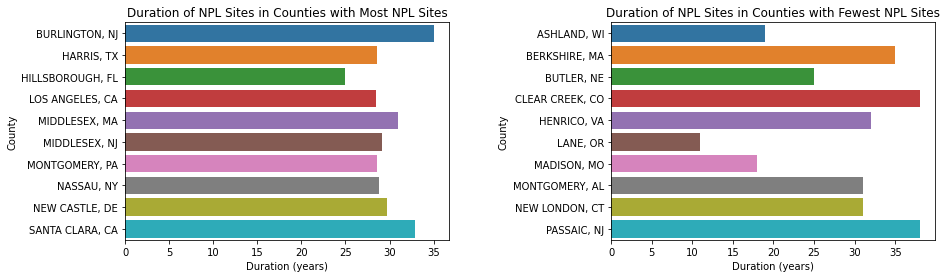

In [31]:
fig, ax =plt.subplots(1,2)
plt.subplots_adjust(left=None, bottom=None, right=2, top=None, wspace=0.5, hspace=None)

ax1 = sns.barplot(x="duration", y="county", data=site_duration_top_df, ax=ax[0], ci=None)
ax1.set_title('Duration of NPL Sites in Counties with Most NPL Sites')
ax1.set_xlabel('Duration (years)')
ax1.set_ylabel('County')

ax2 = sns.barplot(x="duration", y="county", data=site_duration_bottom_df, ax=ax[1], ci=None)
ax2.set_title('Duration of NPL Sites in Counties with Fewest NPL Sites')
ax2.set_xlabel('Duration (years)')
ax2.set_ylabel('County')

In [29]:
pd.merge(site_duration_top_df.describe(), site_duration_bottom_df.describe(), 
         left_index=True, right_index=True, suffixes=('', '2'))

,duration,year,duration2,year2
count,144.000000,144.000000,10.00,10.0
mean,29.777778,1991.222222,27.80,1993.2
...,...,...,...,...
75%,37.000000,1996.000000,34.25,2000.5
max,38.000000,2018.000000,38.00,2010.0


As seen in the models above, the results show that on average, the designation of NPL sites in counties with the most NPL sites tends to be longer compared to NPL sites in counties with the fewest NPL sites. However, again, since the bottom 10 counties might not be generalizable to the rest, this may be giving us misrepresented results. 

The results further insinuate that regions with high NPL sites with long-duration lengths may be affecting the surrounding regions' median household income. The top 10 NPL Sites have progressing remediation processes continuing just over 25 years. As we advance our research, we can expectantly seek to find other factors that may be involved. 